In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())


2.5.1
False


In [2]:
import torch
print(torch.version.cuda)


None


In [3]:
conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia


Channels:
 - pytorch
 - nvidia
 - defaults
Platform: win-64
Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)


False
None


Using device: cpu

Epoch 1/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████| 517/517 [07:37<00:00,  1.13it/s]


Train Loss: 1.5053, Train Acc: 54.99%
Test Loss: 0.3804, Test Acc: 90.14%

Epoch 2/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████| 517/517 [07:35<00:00,  1.14it/s]


Train Loss: 0.5177, Train Acc: 84.32%
Test Loss: 0.2127, Test Acc: 94.29%

Epoch 3/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████| 517/517 [07:27<00:00,  1.16it/s]


Train Loss: 0.3558, Train Acc: 89.32%
Test Loss: 0.1882, Test Acc: 95.28%

Epoch 4/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████| 517/517 [07:12<00:00,  1.19it/s]


Train Loss: 0.2684, Train Acc: 91.74%
Test Loss: 0.1583, Test Acc: 95.82%

Epoch 5/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████| 517/517 [07:02<00:00,  1.22it/s]


Train Loss: 0.2293, Train Acc: 93.04%
Test Loss: 0.1400, Test Acc: 96.19%

Epoch 6/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████| 517/517 [07:04<00:00,  1.22it/s]


Train Loss: 0.1939, Train Acc: 94.00%
Test Loss: 0.1313, Test Acc: 96.27%

Epoch 7/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████| 517/517 [06:41<00:00,  1.29it/s]


Train Loss: 0.1691, Train Acc: 94.68%
Test Loss: 0.1253, Test Acc: 96.53%

Epoch 8/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████| 517/517 [06:23<00:00,  1.35it/s]


Train Loss: 0.1575, Train Acc: 95.09%
Test Loss: 0.1326, Test Acc: 96.53%

Epoch 9/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████| 517/517 [06:53<00:00,  1.25it/s]


Train Loss: 0.1380, Train Acc: 95.62%
Test Loss: 0.1249, Test Acc: 96.67%

Epoch 10/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████| 517/517 [07:43<00:00,  1.12it/s]


Train Loss: 0.1259, Train Acc: 96.01%
Test Loss: 0.1256, Test Acc: 96.83%


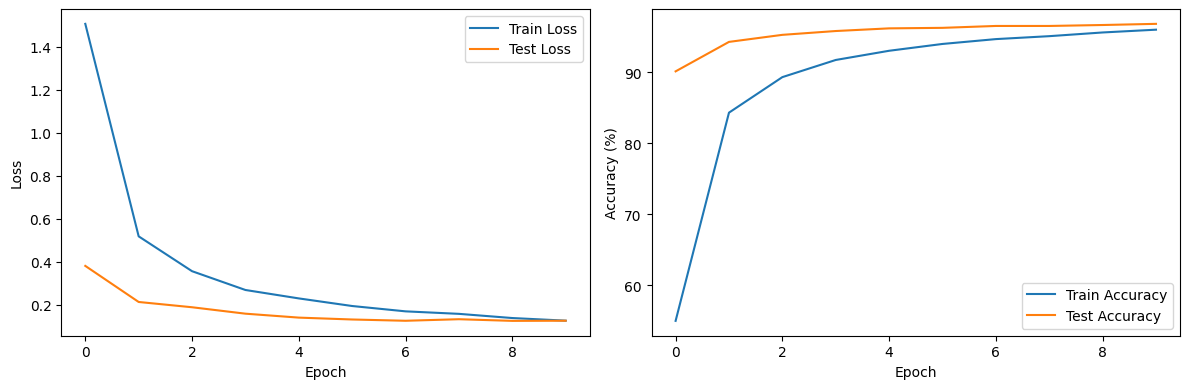


Best Test Accuracy: 96.83%


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dir = "D:/a arsl/train"
test_dir = "D:/a arsl/test"
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Create data loaders with optimized settings for limited GPU
batch_size = 32  # Reduced batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                          num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                         num_workers=2, pin_memory=True)

# Define a smaller model
class ArSLNet(nn.Module):
    def __init__(self, num_classes=32):
        super(ArSLNet, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Initialize model and move to GPU
model = ArSLNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

# Training function
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    epoch_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total
    return epoch_loss, accuracy

# Evaluation function
def evaluate(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(test_loader)
    accuracy = 100. * correct / total
    return epoch_loss, accuracy

# Training loop
num_epochs = 10  # Increased number of epochs
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
best_acc = 0.0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    scheduler.step(test_loss)
    
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_arsl_model.pth')
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    
    # Clear GPU cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nBest Test Accuracy: {best_acc:.2f}%")

# Save class mapping
class_mapping = {i: class_name for i, class_name in enumerate(train_dataset.classes)}
torch.save(class_mapping, 'class_mapping.pth')


In [14]:
import torch
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Device Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU detected'}")


CUDA Available: False
Device Name: No GPU detected


In [16]:
pip install visualkeras

In [32]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import visualkeras
from PIL import Image  # Import Pillow for image handling

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transforms (consistent with training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets (only need test dataset for evaluation)
test_dir = "D:/a arsl/test"  # Corrected the path here
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Create data loaders (only test loader)
batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=2, pin_memory=True)

# Define the model architecture (must match the trained model)
class ArSLNet(nn.Module):
    def __init__(self, num_classes=32):
        super(ArSLNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# Load the trained model
model = ArSLNet(num_classes=len(test_dataset.classes)).to(device) # Initialize with correct num_classes
try:
    model.load_state_dict(torch.load('best_arsl_model.pth'))
    print("Loaded best_arsl_model.pth successfully!")
except FileNotFoundError:
    print("Error: best_arsl_model.pth not found. Make sure it's in the same directory.")
    exit()
except Exception as e:
    print(f"Error loading the model: {e}")
    exit()
model.eval()  # Set to evaluation mode

# Load class mapping
try:
    class_mapping = torch.load('class_mapping.pth')
    print("Loaded class_mapping.pth successfully!")
except FileNotFoundError:
    print("Error: class_mapping.pth not found. Make sure it's in the same directory.")
    exit()
except Exception as e:
    print(f"Error loading class mapping: {e}")
    exit()


# Get predictions on the test set
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Predicting"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 1. Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# 2. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# 3. Model Visualization with visualkeras
try:
    # Ensure visualkeras is installed: pip install visualkeras
    # Requires: pip install pillow
    visualkeras.layered_view(model, legend=True, to_file='network.png')  # Save to file
    img = Image.open('network.png')
    img.show() #attempt to show
    #visualkeras.layered_view(model).show() #This also can be used to show
    print("Model visualized and saved to 'network.png'")

except ImportError as e:
    print(f"Error: Could not import visualkeras or its dependencies.  Please install it with 'pip install visualkeras pillow'.  Original error: {e}")
except Exception as e:
    print(f"An error occurred while visualizing the model: {e}")


# 3. Model Visualization (Conceptual -  Visualizing weights directly is difficult for CNNs.
#   We can show the architecture or activation maps.)

# Option 1: Print Model Architecture (already done above in the class definition, but repeated for clarity)

print("\nModel Architecture:")
print(model)

# Option 2:  (More advanced - Requires more data and processing.)
#Visualizing Activation Maps (a simplified example - pick a layer and a few images)
def visualize_activation_maps(model, test_loader, layer_num=0, num_images=5):
    model.eval()
    count = 0
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        # Extract features from the chosen layer
        activation = None
        def hook_fn(module, input, output):
            global activation
            activation = output.detach().cpu()  # Move to CPU for visualization

        hook = model.features[layer_num].register_forward_hook(hook_fn)


        _ = model(inputs) # Forward pass to trigger the hook

        hook.remove() # Remove hook after extracting the activations
        # Plot the activation maps for selected images
        num_features = activation.shape[1]
        plt.figure(figsize=(15, 3 * num_images))  # Adjust figure size as needed

        for i in range(min(num_images,inputs.shape[0])):

            for j in range(num_features):

                plt.subplot(num_images, num_features, i * num_features + j + 1)
                plt.imshow(activation[i, j, :, :], cmap='viridis')  # Display each feature map
                plt.axis('off')

        plt.tight_layout()
        plt.suptitle(f"Activation Maps - Layer {layer_num} (First {num_images} Images)", y=1.02)  # Overall title
        plt.show()
        break # Only visualize from the first batch


# Example usage of the activation map visualization (uncomment to run -  be mindful of resource usage)
print("\nVisualizing Activation Maps (Layer 0):")
visualize_activation_maps(model, test_loader, layer_num=0, num_images=5)

NameError: name 'Layer' is not defined

In [28]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [30]:
from torchview import draw_graph
import torch

# Assuming 'model' is your PyTorch model (ArSLNet) and 'test_dataset' is defined

# Infer input size from the test dataset's transform
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Example input tensor

try:
    graph = draw_graph(model, input_size=(1, 3, 224, 224), graph_dir='TB', filename='ArSLNet', roll=True, expand_nested=True) # You can customize the input shape if needed
    graph.visual_graph.render(filename='ArSLNet_graph', format='png', view=False)  # Save to a PNG file
    img = Image.open("ArSLNet_graph.png")
    img.show()
    print("Model visualization saved to ArSLNet_graph.png")

except Exception as e:
    print(f"Error generating graph with torchview: {e}")

Error generating graph with torchview: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH


Using device: cpu


C:\Users\Fatima\AppData\Local\Temp\ipykernel_6580\2829731647.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_arsl_model.pth'))


Loaded best_arsl_model.pth successfully!


C:\Users\Fatima\AppData\Local\Temp\ipykernel_6580\2829731647.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_mapping = torch.load('class_mapping.pth')


Loaded class_mapping.pth successfully!


Predicting: 100%|█████████████████████████████████████████████████████████████████████████████████| 517/517 [07:36<00:00,  1.13it/s]



Classification Report:
              precision    recall  f1-score   support

         ain       0.97      0.99      0.98       635
          al       0.98      0.98      0.98       403
       aleff       0.98      0.96      0.97       502
          bb       0.97      0.97      0.97       538
         dal       0.96      0.96      0.96       491
         dha       0.98      0.94      0.96       517
        dhad       0.99      0.97      0.98       501
          fa       0.93      0.95      0.94       587
        gaaf       0.98      0.94      0.96       512
       ghain       0.99      0.96      0.98       594
          ha       0.94      0.96      0.95       478
         haa       0.93      0.96      0.94       458
        jeem       0.97      0.95      0.96       466
        kaaf       0.97      0.96      0.97       533
        khaa       0.96      0.96      0.96       483
          la       0.99      0.98      0.98       524
        laam       0.98      0.99      0.98       550
   

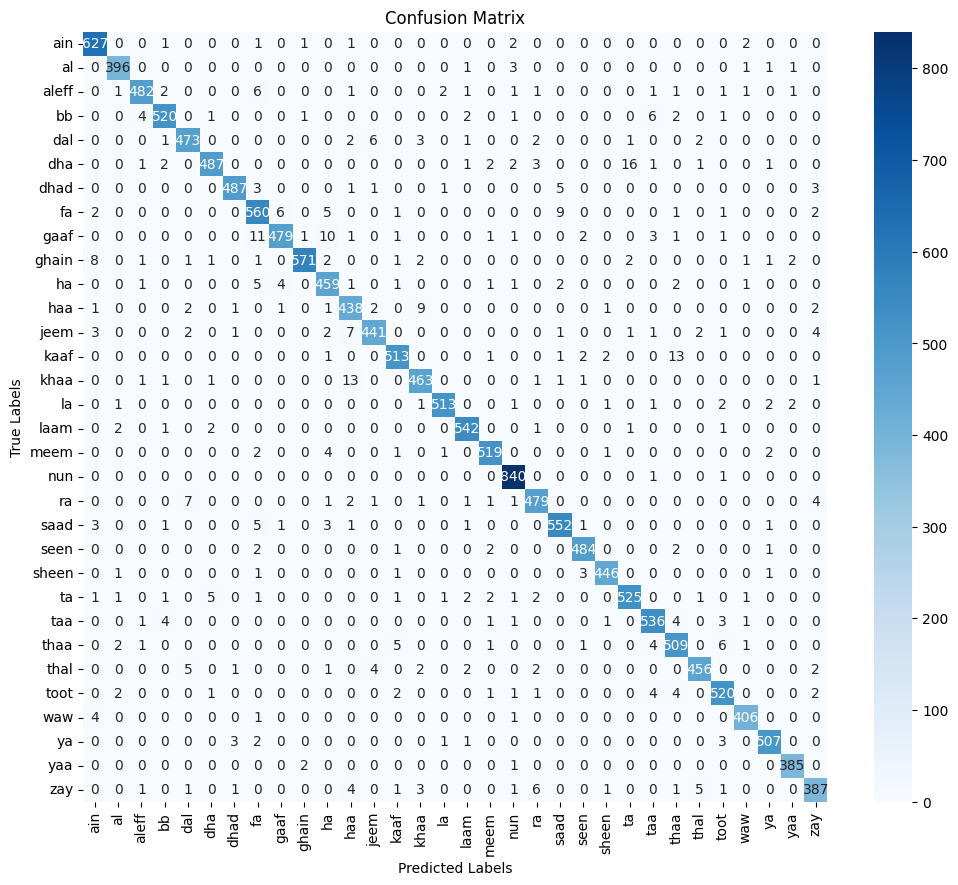

Error generating graph with torchview: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

Model Architecture:
ArSLNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5

AttributeError: 'NoneType' object has no attribute 'shape'

In [33]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
#import visualkeras  # REMOVE this import
from PIL import Image  # Import Pillow for image handling

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transforms (consistent with training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets (only need test dataset for evaluation)
test_dir = "D:/a arsl/test"  # Corrected the path here
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Create data loaders (only test loader)
batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=2, pin_memory=True)

# Define the model architecture (must match the trained model)
class ArSLNet(nn.Module):
    def __init__(self, num_classes=32):
        super(ArSLNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# Load the trained model
model = ArSLNet(num_classes=len(test_dataset.classes)).to(device) # Initialize with correct num_classes
try:
    model.load_state_dict(torch.load('best_arsl_model.pth'))
    print("Loaded best_arsl_model.pth successfully!")
except FileNotFoundError:
    print("Error: best_arsl_model.pth not found. Make sure it's in the same directory.")
    exit()
except Exception as e:
    print(f"Error loading the model: {e}")
    exit()
model.eval()  # Set to evaluation mode

# Load class mapping
try:
    class_mapping = torch.load('class_mapping.pth')
    print("Loaded class_mapping.pth successfully!")
except FileNotFoundError:
    print("Error: class_mapping.pth not found. Make sure it's in the same directory.")
    exit()
except Exception as e:
    print(f"Error loading class mapping: {e}")
    exit()


# Get predictions on the test set
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Predicting"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 1. Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# 2. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# 3. Model Visualization with torchview
from torchview import draw_graph
import torch

# Assuming 'model' is your PyTorch model (ArSLNet) and 'test_dataset' is defined

# Infer input size from the test dataset's transform
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Example input tensor

try:
    graph = draw_graph(model, input_size=(1, 3, 224, 224), graph_dir='TB', filename='ArSLNet', roll=True, expand_nested=True) # You can customize the input shape if needed
    graph.visual_graph.render(filename='ArSLNet_graph', format='png', view=False)  # Save to a PNG file
    img = Image.open("ArSLNet_graph.png")
    img.show()
    print("Model visualization saved to ArSLNet_graph.png")

except Exception as e:
    print(f"Error generating graph with torchview: {e}")

# 3. Model Visualization (Conceptual -  Visualizing weights directly is difficult for CNNs.
#   We can show the architecture or activation maps.)

# Option 1: Print Model Architecture (already done above in the class definition, but repeated for clarity)

print("\nModel Architecture:")
print(model)

# Option 2:  (More advanced - Requires more data and processing.)
#Visualizing Activation Maps (a simplified example - pick a layer and a few images)
def visualize_activation_maps(model, test_loader, layer_num=0, num_images=5):
    model.eval()
    count = 0
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        # Extract features from the chosen layer
        activation = None
        def hook_fn(module, input, output):
            global activation
            activation = output.detach().cpu()  # Move to CPU for visualization

        hook = model.features[layer_num].register_forward_hook(hook_fn)


        _ = model(inputs) # Forward pass to trigger the hook

        hook.remove() # Remove hook after extracting the activations
        # Plot the activation maps for selected images
        num_features = activation.shape[1]
        plt.figure(figsize=(15, 3 * num_images))  # Adjust figure size as needed

        for i in range(min(num_images,inputs.shape[0])):

            for j in range(num_features):

                plt.subplot(num_images, num_features, i * num_features + j + 1)
                plt.imshow(activation[i, j, :, :], cmap='viridis')  # Display each feature map
                plt.axis('off')

        plt.tight_layout()
        plt.suptitle(f"Activation Maps - Layer {layer_num} (First {num_images} Images)", y=1.02)  # Overall title
        plt.show()
        break # Only visualize from the first batch


# Example usage of the activation map visualization (uncomment to run -  be mindful of resource usage)
print("\nVisualizing Activation Maps (Layer 0):")
visualize_activation_maps(model, test_loader, layer_num=0, num_images=5)